In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stat
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import math
import textdistance
import string

In [2]:
df_canvass = pd.read_csv("data/canvass_records.csv.gz")
print("Read {} records.".format(len(df_canvass)))

Read 50462 records.


In [3]:
df_complaint = pd.read_csv("data/complaint_records.csv.gz")
print("Read {} records.".format(len(df_complaint)))

Read 17088 records.


In [4]:
df_canvass.head()

,inspection_id,address,aka_name,city,dba_name,facility_type,inspection_date,inspection_type,latitude,license_id,...,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14
0,1981667,1725 W 47TH ST,BELLAS FUENTEZ,CHICAGO,BELLAS FUENTEZ,Restaurant,2017-01-19T00:00:00.000,Canvass,41.808460,1356217,...,0,0,0,0,0,0,0,0,0,0
1,1453500,65 W JACKSON BLVD,CARVERY,CHICAGO,CARVERY,Restaurant,2014-08-26T00:00:00.000,Canvass,41.878046,43330,...,0,0,0,0,0,0,0,0,0,0
2,1102252,11601 W TOUHY AVE,THE GREAT AMERICAN BAGEL/T3 K2,CHICAGO,THE GREAT AMERICAN BAGEL,Restaurant,2012-05-07T00:00:00.000,Canvass,42.008536,1879167,...,0,0,0,0,0,0,0,0,0,0
3,68091,2804 N CLARK ST,Wells Street Popcorn,CHICAGO,Wells Street Popcorn,Restaurant,2010-02-01T00:00:00.000,Canvass,41.932921,1954774,...,0,0,0,0,0,0,0,0,0,0
4,1482983,1847 W ROSCOE ST,FOUR MOON TAVERN,CHICAGO,FOUR MOON TAVERN,Restaurant,2015-09-14T00:00:00.000,Canvass,41.943141,51644,...,0,0,0,0,0,0,0,0,0,0


In [44]:
df_all = pd.concat([df_canvass, df_complaint])

In [45]:
lid_aka = df_all.groupby("address")["aka_name"].unique()
lid_aka.head()

address
                                              [CASA CENTRAL LA POSADA]
1 E 83RD ST                                                   [SUBWAY]
1 E DELAWARE PL            [STARBUCKS COFFEE #13468, STARBUCKS COFFEE]
1 E JACKSON BLVD     [DEPAUL UNIVERSITY LOOP CAMPUS BOOKSTORE #085,...
1 E PEARSON ST                                     [LOYOLA UNIVERSITY]
Name: aka_name, dtype: object

In [46]:
uniqs = lid_aka.apply(lambda a: len(a))
sorted(zip(uniqs.index, uniqs.values), key=lambda p: p[1], reverse=True)[0:10]

[('11601 W TOUHY AVE ', 167),
 ('1410 S MUSEUM CAMPUS DR ', 50),
 ('1901 W MADISON ST ', 47),
 ('500 W MADISON ST ', 40),
 ('333 W 35TH ST ', 35),
 ('5700 S CICERO AVE ', 34),
 ('131 N CLINTON ST ', 31),
 ('1060 W ADDISON ST ', 29),
 ('222 W MERCHANDISE MART PLZ ', 28),
 ('100 W RANDOLPH ST ', 25)]

In [47]:
name_df = pd.DataFrame({"Address": lid_aka.index, "Names": lid_aka.values})
name_df["N"] = name_df["Names"].apply(lambda a: len(a))
name_df.sort_values(by="N", ascending=False).head(30)

,Address,Names,N
624,11601 W TOUHY AVE,"[THE GREAT AMERICAN BAGEL/T3 K2, REGGIO'S PIZZ...",167
1083,1410 S MUSEUM CAMPUS DR,"[2ND CITY PIZZA, BREWS BROTHER, DRY STORAGE CO...",50
1956,1901 W MADISON ST,"[MAIN KITCHEN, NBA-NHL BANQUET ROOM S-207, CAR...",47
6142,500 W MADISON ST,"[MADISON TAVERN, GARRETT'S POPCORN SHOPS, SLIC...",40
4356,333 W 35TH ST,"[LUKE APPLING'S ALL STAR STAND #510, GROUNDS K...",35
6824,5700 S CICERO AVE,"[BARISTA EXPRESS, MC DONALD'S, MILLERS PUB, LA...",34
875,131 N CLINTON ST,"[POLPETTI, SPICY MONKEY SOUP CO., nan, WOOD FI...",31
277,1060 W ADDISON ST,"[Upper Left Commissary #9094, THE CUB HOUSE #1...",29
2635,222 W MERCHANDISE MART PLZ,"[THE ARTISAN CELLARS, AU BON PAIN, POTBELLY SA...",28
7044,600 E GRAND AVE,"[COMPLETELY NUTS, INC., CHICAGO ELITE, STARBUC...",25


In [51]:
zoot_all = df_all.groupby("address")["inspection_id"].count().sort_values(ascending=False)
dict_all = {"Names": [lid_aka[z] for z in zoot_all.index], "Count": zoot_all.values}
zdf_all = pd.DataFrame(dict_all)
zdf_all.head(30)

,Names,Count
0,"[THE GREAT AMERICAN BAGEL/T3 K2, REGGIO'S PIZZ...",1425
1,"[BARISTA EXPRESS, MC DONALD'S, MILLERS PUB, LA...",289
2,"[MADISON TAVERN, GARRETT'S POPCORN SHOPS, SLIC...",230
3,"[PINKYS RESTAURANT, TOKYO LUNCH BOXES & CATERI...",183
4,"[MCDONALD'S #11290, WENDY'S, IHOP, SUBWAY, THE...",139
5,"[THE ARTISAN CELLARS, AU BON PAIN, POTBELLY SA...",135
6,"[HARRY CARAY'S TAVERN NAVY PIER, CAPI'S ITALIA...",130
7,"[2ND CITY PIZZA, BREWS BROTHER, DRY STORAGE CO...",129
8,"[LUKE APPLING'S ALL STAR STAND #510, GROUNDS K...",114
9,"[Upper Left Commissary #9094, THE CUB HOUSE #1...",113


In [48]:
zoot_canvass = df_canvass.groupby("address")["inspection_id"].count().sort_values(ascending=False)
dict_canvass = {"Names": [lid_aka[z] for z in zoot_canvass.index], "Count": zoot_canvass.values}
zdf_canvass = pd.DataFrame(dict_canvass)
zdf_canvass.head(20)

,Names,Count
0,"[THE GREAT AMERICAN BAGEL/T3 K2, REGGIO'S PIZZ...",1275
1,"[BARISTA EXPRESS, MC DONALD'S, MILLERS PUB, LA...",253
2,"[MADISON TAVERN, GARRETT'S POPCORN SHOPS, SLIC...",177
3,"[2ND CITY PIZZA, BREWS BROTHER, DRY STORAGE CO...",128
4,"[THE ARTISAN CELLARS, AU BON PAIN, POTBELLY SA...",121
5,"[PINKYS RESTAURANT, TOKYO LUNCH BOXES & CATERI...",117
6,"[LUKE APPLING'S ALL STAR STAND #510, GROUNDS K...",108
7,"[HARRY CARAY'S TAVERN NAVY PIER, CAPI'S ITALIA...",107
8,"[Upper Left Commissary #9094, THE CUB HOUSE #1...",103
9,"[MCDONALD'S #11290, WENDY'S, IHOP, SUBWAY, THE...",101


In [49]:
zoot_complaint = df_complaint.groupby("address")["inspection_id"].count().sort_values(ascending=False)
dict_complaint = {"Names": [lid_aka[z] for z in zoot_complaint.index], "Count": zoot_complaint.values}
zdf_complaint = pd.DataFrame(dict_complaint)
zdf_complaint.head(20)

,Names,Count
0,"[THE GREAT AMERICAN BAGEL/T3 K2, REGGIO'S PIZZ...",150
1,"[PINKYS RESTAURANT, TOKYO LUNCH BOXES & CATERI...",66
2,"[MADISON TAVERN, GARRETT'S POPCORN SHOPS, SLIC...",53
3,[MCDONALD'S],42
4,"[SUBWAY, FIREHOUSE OF DAN RYAN, INC., GRAND CH...",40
5,"[MCDONALD'S #11290, WENDY'S, IHOP, SUBWAY, THE...",38
6,"[LONG TUNG CHINESE KITCHEN, DUNKIN DONUTS, SHA...",37
7,"[BARISTA EXPRESS, MC DONALD'S, MILLERS PUB, LA...",36
8,"[DUNKIN DONUTS / BASKIN ROBBINS, DUNKIN DONUTS...",35
9,"[NEW WAYNE'S BARBECUE & CAJUN INC, SUBWAY, New...",33


In [5]:
textdistance.jaro_winkler.similarity("McDONALDS".casefold(), "MCDONALDS RESTAURANT".casefold())

0.89

In [6]:
names = list(df_complaint.groupby("aka_name")["inspection_id"].count().sort_values(ascending=False).head(500).index)

In [7]:
def clean_name(name, banned):
    cleaned = name.casefold()
    for ban in banned:
        cleaned = cleaned.replace(ban, "")
    return cleaned

In [20]:
BANNED = list(string.punctuation) + [
    "restaurant",
    "star ",
    "house",
    "kitchen",
    "original",
    "the"
] + [" "]
BANNED = [ban.casefold() for ban in BANNED]

In [21]:
mat = np.zeros((len(names), len(names)))
pairs = []
for i, a in enumerate(names):
    for j, b in enumerate(names):
        a_clean = clean_name(a, BANNED)
        b_clean = clean_name(b, BANNED)
        sim = textdistance.jaro_winkler.similarity(a_clean, b_clean)
        mat[i][j] = sim
        if j > i:
            pairs.append((i, j, a_clean, b_clean, sim))
print(len(pairs), ((len(names)**2) - len(names)) // 2)

124750 124750


In [22]:
pd.DataFrame(mat, columns=names, index=names).head()

,SUBWAY,MCDONALD'S,DUNKIN DONUTS,MCDONALDS,BURGER KING,CHIPOTLE MEXICAN GRILL,WENDY'S,DUNKIN DONUTS/BASKIN ROBBINS,HAROLD'S CHICKEN SHACK,MC DONALD'S,...,JJ FISH & CHICKEN,FORNELLO TRATTORIA,JOHN'S DRIVE INN,"FOOD LIFE/LETTUCE OFF PREM, CA",UNCOMMON GROUND,BURGER KING #1512,BURGER KING #1310,BURGER KING #12371,WOW BAO,Jimmy Johns
SUBWAY,1.000000,0.425926,0.416667,0.425926,0.344444,0.405556,0.444444,0.525556,0.312865,0.425926,...,0.414530,0.408497,0.414530,0.402778,0.412698,0.325397,0.325397,0.322222,0.555556,0.422222
MCDONALD'S,0.425926,1.000000,0.557407,1.000000,0.403704,0.435185,0.500000,0.496667,0.494152,1.000000,...,0.292023,0.476580,0.417379,0.375000,0.570899,0.394180,0.394180,0.392593,0.518519,0.614815
DUNKIN DONUTS,0.416667,0.557407,1.000000,0.557407,0.577778,0.386111,0.333333,0.896000,0.438596,0.557407,...,0.440171,0.364379,0.463675,0.408333,0.531746,0.414683,0.414683,0.408333,0.416667,0.494444
MCDONALDS,0.425926,1.000000,0.557407,1.000000,0.403704,0.435185,0.500000,0.496667,0.494152,1.000000,...,0.292023,0.476580,0.417379,0.375000,0.570899,0.394180,0.394180,0.392593,0.518519,0.614815
BURGER KING,0.344444,0.403704,0.577778,0.403704,1.000000,0.450000,0.422222,0.395000,0.521053,0.403704,...,0.399145,0.420098,0.444231,0.363889,0.436905,0.942857,0.942857,0.933333,0.422222,0.400000


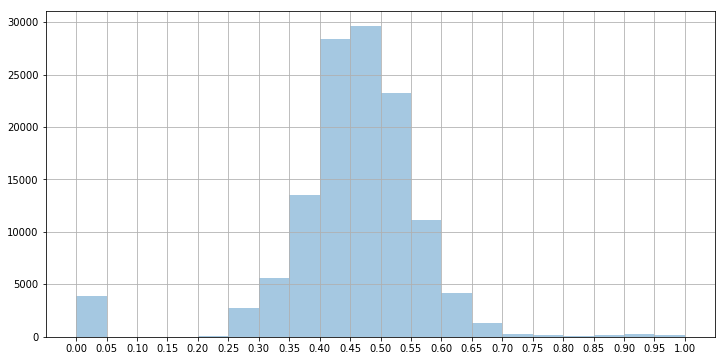

In [23]:
sns.distplot([p[4] for p in pairs], kde=False, bins=np.arange(0, 1.05, 0.05))
plt.xticks(np.arange(0, 1.05, 0.05))
plt.grid()
plt.gcf().set_size_inches(12, 6)
plt.show()

In [24]:
pair_df = pd.DataFrame(pairs, columns=["i", "j", "a", "b", "sim"])
pair_df.sort_values(by="sim", ascending=False).query("sim <= 0.85 and sim >= 0.80")

,i,j,a,b,sim
119774,399,474,tastysub,tastyinc,0.850000
38357,83,427,newchinabuffet,newchinaexpress,0.848571
12409,25,260,kentuckyfriedchicken,kennedyfishchicken,0.848333
92677,246,305,shakeshack,sharksfishandchicken,0.848333
106484,308,379,taqueriaarcher,taqueriaatotonilco1,0.848120
17582,36,285,tacobell,kfctacobell,0.846591
36649,79,389,popeyesfriedchicken,popeyeschickenindianswaad,0.846421
58177,134,357,newgrandchinese,newranchsteak,0.845043
3397,6,425,wendys,wendysoldfashionedhamburger,0.844444
71047,171,425,wendys,wendysoldfashionedhamburger,0.844444


In [25]:
min_sim = 0.84
matches = pair_df.query("sim >= {}".format(min_sim))
match_idxs = [(a[0], a[1]) for a in matches.values]
clusters = []
for idx_pair in match_idxs:
    i, j = idx_pair
    found = False
    for cluster in clusters:
        if i in cluster or j in cluster:
            cluster.add(i)
            cluster.add(j)
            found = True
            break
    if not found:
        clusters.append(set([i, j]))
[list(np.unique([names[i] for i in a])) for a in clusters]

[['SUBWAY',
  'SUBWAY SANDWICH & SALAD',
  'SUBWAY SANDWICHES',
  'SUBWAY SANDWICHES & SALADS',
  'Subway'],
 ["MC DONALD'S",
  'MC DONALDS',
  'MCDONALD',
  "MCDONALD' S # 5618",
  "MCDONALD'S",
  "MCDONALD'S #490",
  "MCDONALD'S #5813",
  "MCDONALD'S CORPORATION",
  "MCDONALD'S RESTAURANT",
  "MCDONALD'S RESTAURANTS",
  'MCDONALDS',
  'MCDONALDS #27672',
  'MCDONALDS RESTAURANT',
  'Mc DONALDS',
  'Mc DONALDS # 6771',
  "McDONALD'S",
  'McDONALDS',
  "McDonald's",
  "McDonald's Restaurant",
  'McDonalds',
  'McDonalds#6337'],
 ['DUNKIN DONUTS',
  'DUNKIN DONUTS / BASKIN ROBBINS',
  'DUNKIN DONUTS / BASKIN ROBINS',
  'DUNKIN DONUTS BASKIN ROBBINS',
  'DUNKIN DONUTS/ BASKIN ROBBINS',
  'DUNKIN DONUTS/BASKIN ROBBINS'],
 ['BURGER KING',
  'BURGER KING #',
  'BURGER KING #10366',
  'BURGER KING #12371',
  'BURGER KING #1272',
  'BURGER KING #1310',
  'BURGER KING #1512',
  'BURGER KING #181',
  'BURGER KING #7623',
  'BURGER KING #7674'],
 ['CHIPOTLE', 'CHIPOTLE MEXICAN GRILL', 'Chipotle 